In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

working_dir = "/epyc/projects/dschaub/method-projects/spatialnca"
import os

os.chdir(working_dir)
import scanpy as sc
import torch

import matplotlib.pyplot as plt

from spatialnca.data import prepare_data
from spatialnca.model import SpatialNCA
from spatialnca.train import Trainer

from spatialnca.utils import (
    align_point_clouds,
    seed_everything,
    spatial_scatter,
    plot_pyg,
    construct_graph,
    generate_grid_adata,
)
from spatialnca.config import Config

from torch_geometric.transforms.delaunay import Delaunay
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

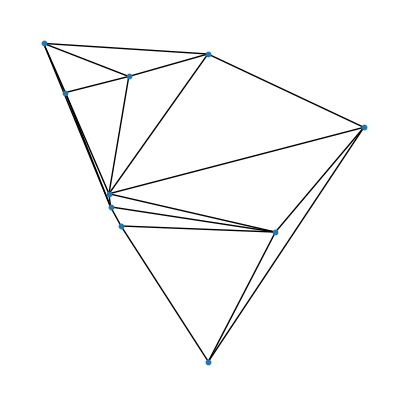

In [2]:
pos = torch.randn(10, 2)
edge_index = construct_graph(pos, knn=2, delaunay=True)
plot_pyg(edge_index, pos=pos)

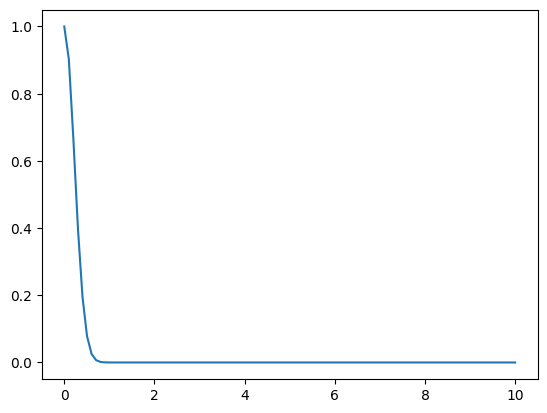

In [3]:
def exp_kernel(x, sigma):
    return torch.exp(-sigma * x**2)


x_values = torch.linspace(0, 10, 100)
y_values = exp_kernel(x_values, 10)
plt.plot(x_values, y_values)
plt.show()

## Load data

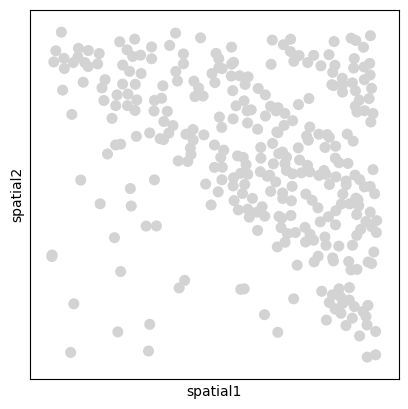

AnnData object with n_obs × n_vars = 318 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'abc_sample_id', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color', 'domain', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_identifier'
    uns: 'parcellation_substructure_colors', 'subclass_colors'
    obsm: 'spatial'

In [4]:
path = "data/Zhuang-ABCA-3.003_slice.h5ad"
adata = sc.read_h5ad(path)
sc.pl.spatial(adata, color=None, spot_size=0.01)
adata

In [5]:
# create grid anndata
# adata = generate_grid_adata((10, 10))
# sc.pl.spatial(adata, color=None, spot_size=0.05)

In [6]:
base_cfg = Config()
cfg = Config()
# cfg.emb_key = None
# cfg.add_init = True
# cfg.act = "gelu"
# cfg.gpt2_weight_init = True
# cfg.pos_init_fn = "uniform"
# cfg.pos_init_fn = "sunflower"
# cfg.knn = 200
cfg.fixed_edge_index = False
# cfg.n_epochs = int(1e6)
# cfg.n_epochs = 20000
# cfg.intm_loss = True
# cfg.normalize_diff = True
# cfg.max_coord_upd_norm = 1.0
# cfg.complete = True
# cfg.sigma_init = 0.0
# cfg.delaunay = True
# cfg.knn = None
cfg.pos_init_fn = "random_walk"
cfg.pos_init_kwargs = {"num_steps": 5}

diff = cfg - base_cfg
if len(diff) > 0:
    diff_str = ",\n".join([f"{k}={v}" for k, v in diff.items()])
else:
    diff_str = "Default config"
clean_diff_str = diff_str.replace(", ", "_").replace("\n", "_")
print(diff_str)

fixed_edge_index=True->False,
pos_init_fn=gaussian->random_walk,
pos_init_kwargs=None->{'num_steps': 5}


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

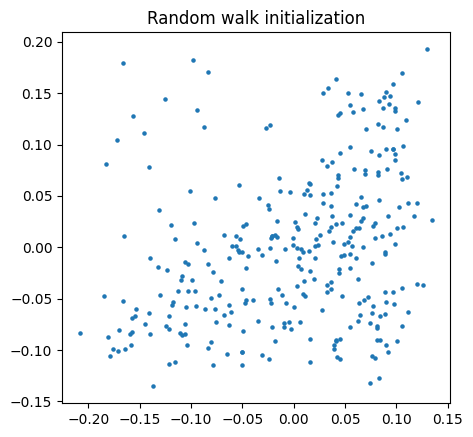

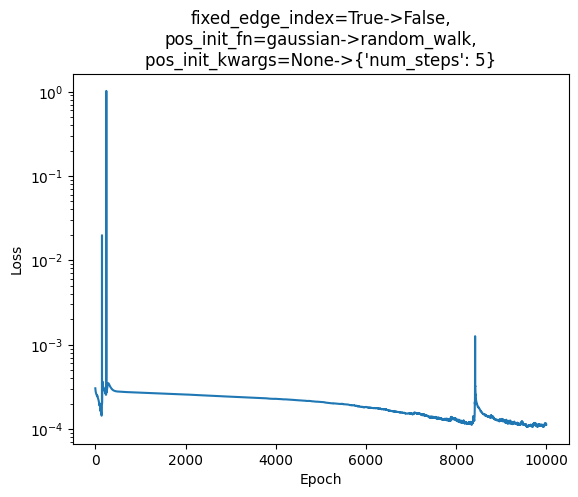

In [7]:
# seed everything
seed_everything(cfg.seed)

data = prepare_data(adata, cfg, construct_edge_index=cfg.fixed_edge_index)

spnca = SpatialNCA(
    data.num_features,
    cfg,
)

trainer = Trainer(model=spnca, cfg=cfg)

trainer.train(data)

trainer.plot_history(title=diff_str, save_path=f"figures/history_{clean_diff_str}.png")

torch.save(spnca, f"checkpoints/trained_model_{clean_diff_str}.pt")

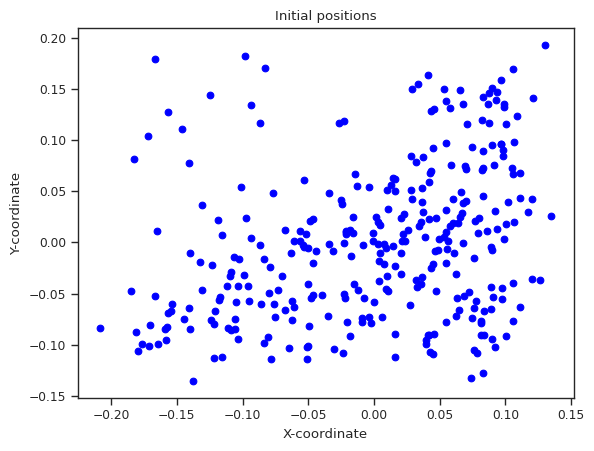

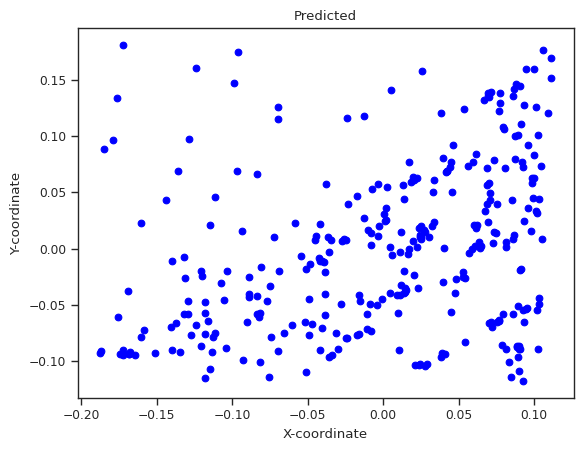

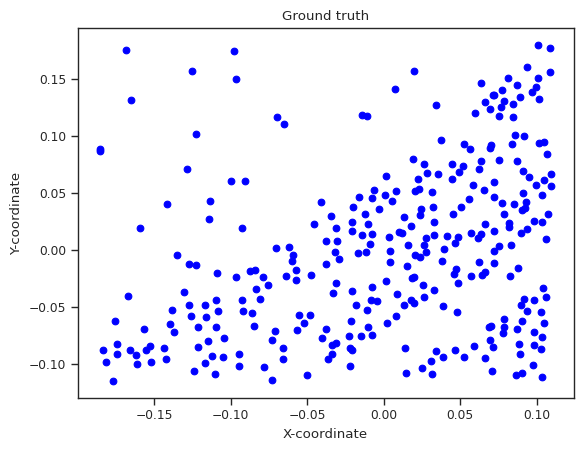

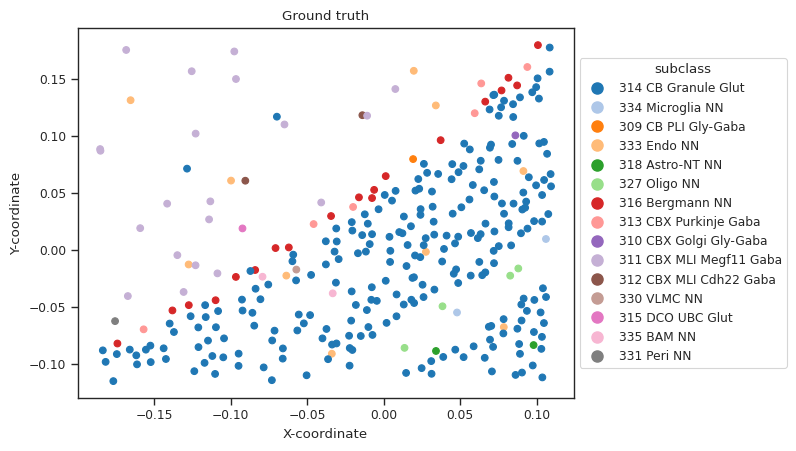

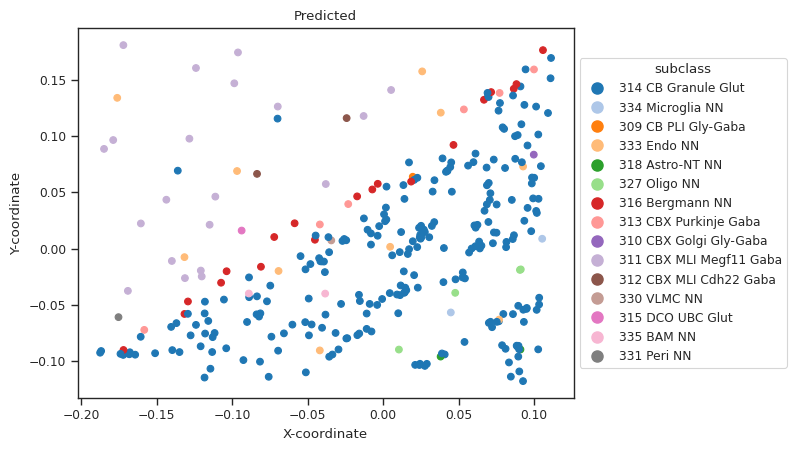

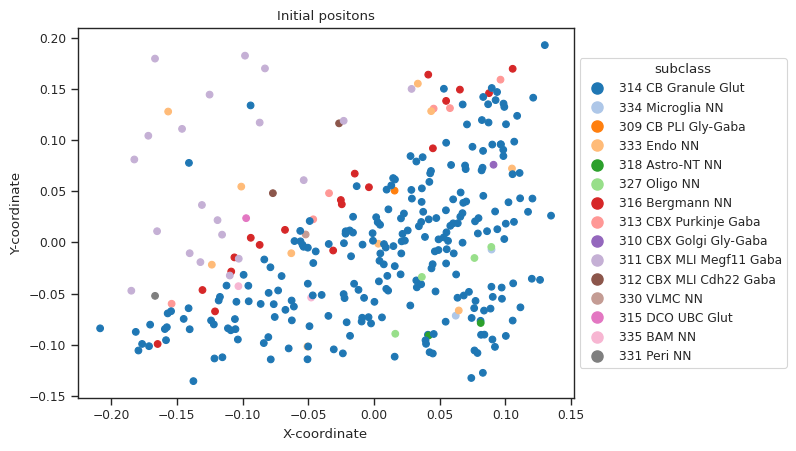

In [8]:
# perform another rollout to check the result
n_steps = cfg.n_steps
# n_steps = 100

h, pos, edge_index, _ = spnca.rollout(
    x=data.x, pos=data.pos_init, n_steps=n_steps, edge_index=data.edge_index
)

# convert to anndata for plotting
ad_init = adata.copy()
ad_init.obsm["spatial"] = data.pos_init.cpu().detach().numpy()

ad_final = adata.copy()
ad_final.obsm["spatial"] = pos.cpu().detach().numpy()


spatial_scatter(ad_init, color=None, title="Initial positions")
spatial_scatter(ad_final, color=None, title="Predicted")
spatial_scatter(adata, color=None, title="Ground truth")

if "subclass" in adata.obs.columns:
    spatial_scatter(adata, color="subclass", title="Ground truth")
    spatial_scatter(ad_final, color="subclass", title="Predicted")
    spatial_scatter(ad_init, color="subclass", title="Initial positons")

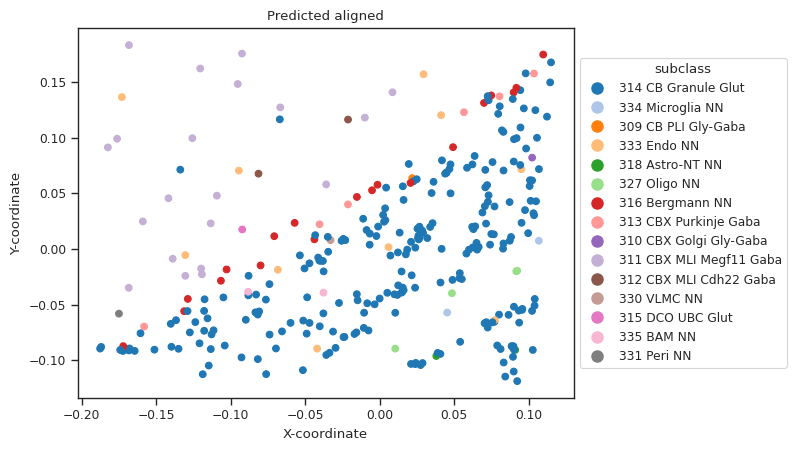

In [9]:
pos_pred = pos.detach().cpu().numpy()
pos_true = adata.obsm["spatial"]
R, t = align_point_clouds(pos_pred, pos_true)
pos_pred_aligned = pos_pred @ R + t
ad_final_aligned = ad_final.copy()
ad_final_aligned.obsm["spatial"] = pos_pred_aligned
spatial_scatter(ad_final_aligned, color="subclass", title="Predicted aligned")

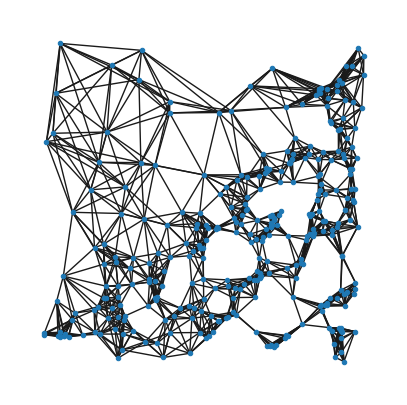

In [10]:
plot_pyg(edge_index, pos=pos)

In [11]:
# print(f"Sigma: {spnca.mpnn.kernel.sigma}")
# if spnca.mpnn.kernel:
#     x_values = torch.linspace(0, 10, 100).to(spnca.device)
#     y_values = spnca.mpnn.kernel(x_values)
#     plt.plot(x_values.detach().cpu().numpy(), y_values.detach().cpu().numpy())
#     plt.show()